In [56]:
# load in libraries
import pandas as pd
import os
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [57]:
# Read in processed airports data
# Airports with aerial firefighting capabilities
airports_dir = os.path.join(os.getcwd(), '../data/raw_data/airports_processed.csv')
airports = pd.read_csv(airports_dir)

In [58]:
# view
airports.head()

,ident,iata_code,icao_code,local_code,name,type,latitude_deg,longitude_deg,elevation_ft,country_name,region_name,runway_lengths_ft,runway_surfaces,airtanker_base
0,0R7,NaN,NaN,0R7,The Red River Airport,small_airport,31.990700,-93.307404,177.0,United States,Louisiana,5000,asphalt,False
1,5K2,NaN,NaN,5K2,Tribune Municipal Airport,small_airport,38.450901,-101.750135,3620.0,United States,Kansas,5000,grooved concrete,False
2,C56,NaN,NaN,C56,Bult Field,small_airport,41.377602,-87.681396,790.0,United States,Illinois,5001,grooved concrete,False
3,D38,IUA,NaN,IUA,Canandaigua Airport,small_airport,42.908902,-77.325226,814.0,United States,New York,5500,asphalt,False
4,FWB,NaN,NaN,FWB,Branson West Airport,small_airport,36.698497,-93.402249,1348.0,United States,Missouri,5000,grooved concrete,False


In [59]:
# get data info
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ident              1394 non-null   object 
 1   iata_code          1006 non-null   object 
 2   icao_code          965 non-null    object 
 3   local_code         1394 non-null   object 
 4   name               1394 non-null   object 
 5   type               1394 non-null   object 
 6   latitude_deg       1394 non-null   float64
 7   longitude_deg      1394 non-null   float64
 8   elevation_ft       1394 non-null   float64
 9   country_name       1394 non-null   object 
 10  region_name        1394 non-null   object 
 11  runway_lengths_ft  1394 non-null   object 
 12  runway_surfaces    1394 non-null   object 
 13  airtanker_base     1394 non-null   bool   
dtypes: bool(1), float64(3), object(10)
memory usage: 143.1+ KB


In [60]:
# Count null values in each column of the filtered dataset
null_counts = airports.isnull().sum()
# Print the result
print("Null values in each column:")
print(null_counts.sort_values(ascending=False))

Null values in each column:
icao_code            429
iata_code            388
ident                  0
local_code             0
name                   0
type                   0
latitude_deg           0
longitude_deg          0
elevation_ft           0
country_name           0
region_name            0
runway_lengths_ft      0
runway_surfaces        0
airtanker_base         0
dtype: int64


In [61]:
# compute the number of airports in the US actually have wildfire capabilities
# get all airports
airports_raw_dir = os.path.join(os.getcwd(), '../data/raw_data/our_airports_raw/airports.csv')
airports_raw = pd.read_csv(
    airports_raw_dir
)

# Filter all U.S. airports from raw dataset
us_airports = airports_raw[airports_raw['iso_country'] == 'US']
total_us_airports = len(us_airports)

# Get number of aerial firefighting airports (already filtered to US)
num_firefighting_airports = len(airports)

# Compute proportion
proportion = num_firefighting_airports / total_us_airports if total_us_airports > 0 else 0
percentage = proportion * 100

# Output fraction and percentage
print(f"Fraction of U.S. airports with aerial firefighting capabilities: "
      f"{num_firefighting_airports}/{total_us_airports}")

print(f"Percentage of U.S. airports with aerial firefighting capabilities: "
      f"{percentage:.2f}%")

Fraction of U.S. airports with aerial firefighting capabilities: 1394/32098
Percentage of U.S. airports with aerial firefighting capabilities: 4.34%


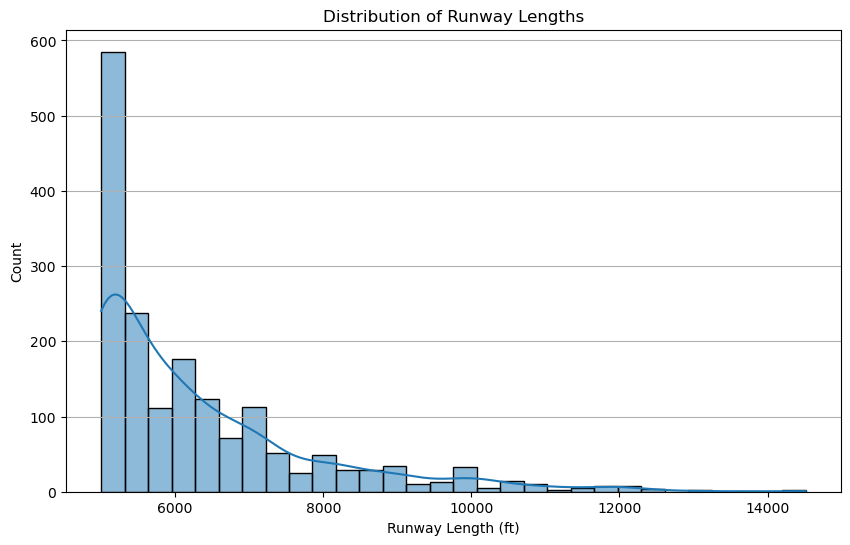

In [62]:
# Convert runway_lengths_ft to list of ints
airports['runway_lengths_list'] = airports['runway_lengths_ft'].apply(
    lambda x: [int(i) for i in str(x).split(',') if i.strip().isdigit()] if pd.notnull(x) else []
)

# Explode for histogram of individual runway lengths
runway_lengths_all = airports.explode('runway_lengths_list')
runway_lengths_all['runway_lengths_list'] = runway_lengths_all['runway_lengths_list'].astype(float)

plt.figure(figsize=(10, 6))
ax = sns.histplot(runway_lengths_all['runway_lengths_list'], bins=30, kde=True)
plt.xlabel('Runway Length (ft)')
plt.title('Distribution of Runway Lengths')

# Only show horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

plt.show()


In [63]:
# Compute stats
runway_series = runway_lengths_all['runway_lengths_list']
runway_stats = runway_series.describe()
iqr = runway_stats['75%'] - runway_stats['25%']
mode_val = runway_series.mode()

# Outlier thresholds
lower_bound = runway_stats['25%'] - 1.5 * iqr
upper_bound = runway_stats['75%'] + 1.5 * iqr

# Identify outliers
outliers = runway_series[(runway_series < lower_bound) | (runway_series > upper_bound)]

# Summary output
print("Runway Lengths Statistics (ft):")
print(f"Mode: {mode_val.iloc[0] if not mode_val.empty else 'No mode'}")
print(f"Mean: {runway_stats['mean']:.2f}")
print(f"Median: {runway_series.median():.2f}")
print(f"Std: {runway_stats['std']:.2f}")
print(f"IQR: {iqr:.2f}")
print(f"Min: {runway_stats['min']}")
print(f"Max: {runway_stats['max']}")

# Get the rows with the minimum and maximum runway lengths
min_runway_row = runway_lengths_all.loc[runway_lengths_all['runway_lengths_list'].idxmin()]
max_runway_row = runway_lengths_all.loc[runway_lengths_all['runway_lengths_list'].idxmax()]

print("\nAirport with the Shortest Runway:")
print(f"Name: {min_runway_row['name']}")
print(f"Runway Length: {min_runway_row['runway_lengths_list']} ft")

print("\nAirport with the Longest Runway:")
print(f"Name: {max_runway_row['name']}")
print(f"Runway Length: {max_runway_row['runway_lengths_list']} ft")

print(f"\nOutlier Thresholds: < {lower_bound:.2f} or > {upper_bound:.2f}")
print(f"Number of Outliers: {len(outliers)}")

# Optional: print extreme outliers
if not outliers.empty:
    print("\nSample Outliers:")
    print(outliers.sort_values().head(5))
    print(outliers.sort_values(ascending=False).head(5))


Runway Lengths Statistics (ft):
Mode: 5000.0
Mean: 6298.81
Median: 5800.00
Std: 1557.68
IQR: 1862.00
Min: 5000.0
Max: 14515.0

Airport with the Shortest Runway:
Name: The Red River Airport
Runway Length: 5000.0 ft

Airport with the Longest Runway:
Name: 749    Harry Reid International Airport
749    Harry Reid International Airport
749    Harry Reid International Airport
Name: name, dtype: object
Runway Length: 749     9771.0
749    10526.0
749    14515.0
Name: runway_lengths_list, dtype: float64 ft

Outlier Thresholds: < 2307.00 or > 9755.00
Number of Outliers: 92

Sample Outliers:
247      9763.0
749      9771.0
1393     9800.0
1103     9999.0
116     10000.0
Name: runway_lengths_list, dtype: float64
749    14515.0
717    14511.0
108    13793.0
388    13125.0
863    13000.0
Name: runway_lengths_list, dtype: float64


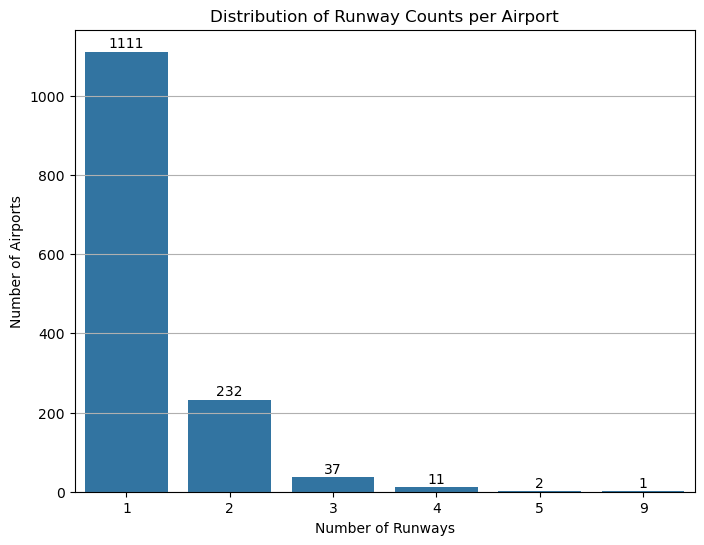

In [64]:
# Analyze Number of Runways per Airport
airports['num_runways'] = airports['runway_lengths_list'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=airports['num_runways'])

plt.xlabel('Number of Runways')
plt.ylabel('Number of Airports')
plt.title('Distribution of Runway Counts per Airport')

# Show only horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Add count labels above bars
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 10, str(count), ha='center')

plt.show()


In [65]:
# Descriptive Stats for runway counts
runway_count_stats = airports['num_runways'].describe()
iqr_runways = runway_count_stats['75%'] - runway_count_stats['25%']

print("\nNumber of Runways per Airport Statistics:")
print(f"Mode: {airports['num_runways'].mode()[0]}")
print(f"Min: {runway_count_stats['min']}")
print(f"Max: {runway_count_stats['max']}")

# Optional: frequency table
print("\nRunway Count Frequencies:")
print(airports['num_runways'].value_counts().sort_index())



Number of Runways per Airport Statistics:
Mode: 1
Min: 1.0
Max: 9.0

Runway Count Frequencies:
num_runways
1    1111
2     232
3      37
4      11
5       2
9       1
Name: count, dtype: int64


In [66]:
# Find the min and max number of runways
min_runways = airports['num_runways'].min()
max_runways = airports['num_runways'].max()

# Filter airports with min and max number of runways
airports_with_min_runways = airports[airports['num_runways'] == min_runways]
airports_with_max_runways = airports[airports['num_runways'] == max_runways]

# Output results
print(f"\nAirports with the Fewest Runways ({min_runways} runway):")
print(airports_with_min_runways) # [['name', 'ident', 'num_runways']])

print(f"\nAirports with the Most Runways ({max_runways} runways):")
print(airports_with_max_runways) #[['name', 'ident', 'num_runways']])


Airports with the Fewest Runways (1 runway):
     ident iata_code icao_code local_code  \
0      0R7       NaN       NaN        0R7   
1      5K2       NaN       NaN        5K2   
2      C56       NaN       NaN        C56   
3      D38       IUA       NaN        IUA   
4      FWB       NaN       NaN        FWB   
...    ...       ...       ...        ...   
1385  PHHI       HHI      PHHI        HHI   
1387  PHKO       KOA      PHKO        KOA   
1389  PHMU       MUE      PHMU        MUE   
1391  PHNY       LNY      PHNY        LNY   
1392  PHOG       OGG      PHOG        OGG   

                                                   name            type  \
0                                 The Red River Airport   small_airport   
1                             Tribune Municipal Airport   small_airport   
2                                            Bult Field   small_airport   
3                                   Canandaigua Airport   small_airport   
4                                  Bra

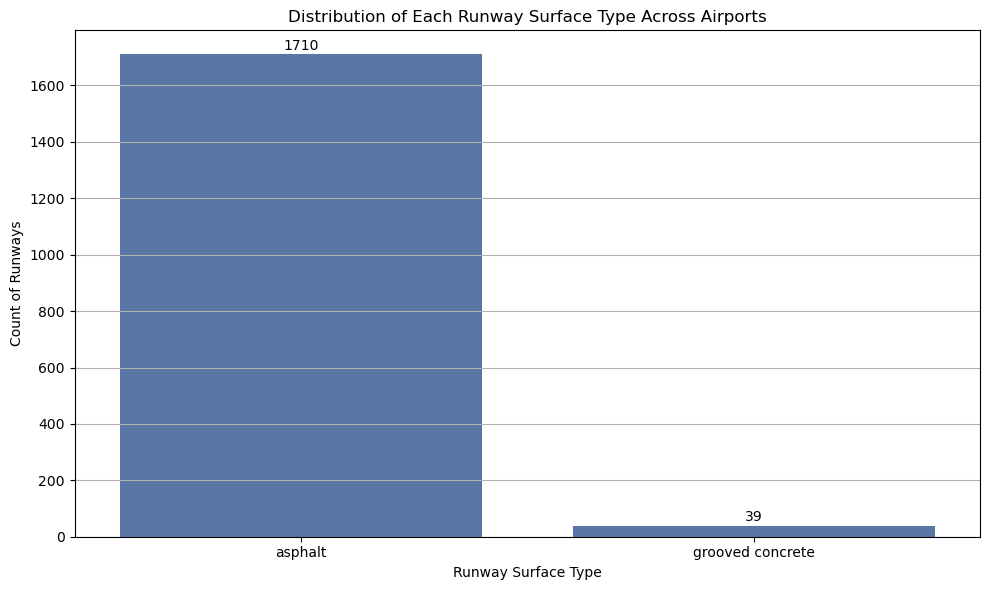

In [67]:
# Convert 'runway_surfaces' strings to lists
airports['runway_surfaces_list'] = airports['runway_surfaces'].dropna().apply(
    lambda x: [s.strip() for s in str(x).split(',')]
)

# Explode so each surface is a row
surfaces_all = airports.explode('runway_surfaces_list')

# Count occurrences of each surface
surface_counts = surfaces_all['runway_surfaces_list'].value_counts().sort_values(ascending=False)

# Get the default deep palette first color (Seaborn's default blue)
default_blue = sns.color_palette("deep")[0]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=surface_counts.index, y=surface_counts.values, color=default_blue)

plt.xlabel('Runway Surface Type')
plt.ylabel('Count of Runways')
plt.title('Distribution of Each Runway Surface Type Across Airports')

# Show only horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + max(surface_counts.values)*0.01, str(count), ha='center')

plt.tight_layout()
plt.show()


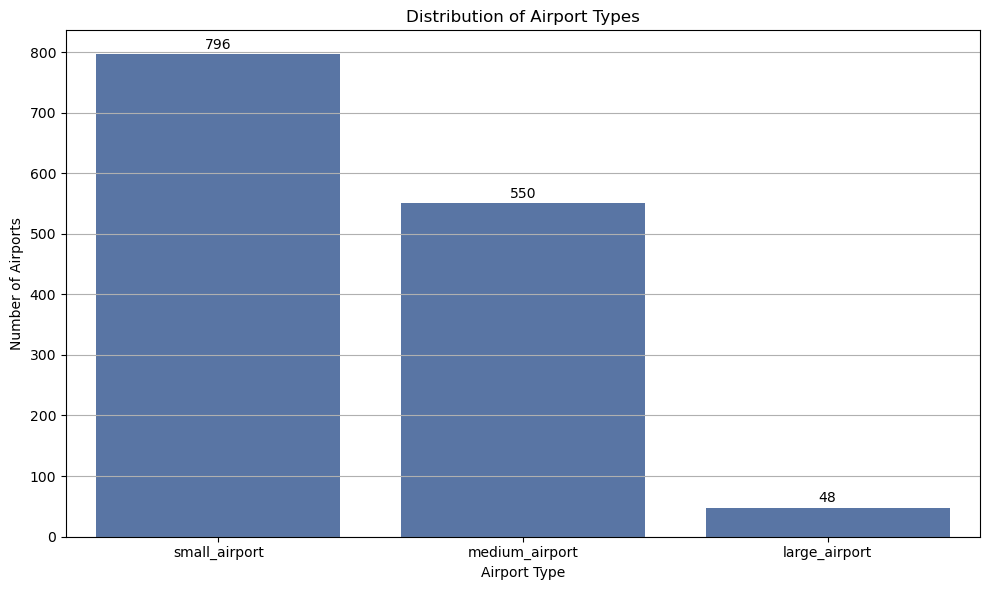

In [68]:
# airport type plot

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=airports, x='type', color=sns.color_palette("deep")[0])

plt.xlabel('Airport Type')
plt.ylabel('Number of Airports')
plt.title('Distribution of Airport Types')

# Show only horizontal grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + max(ax.get_ylim())*0.01, str(count), ha='center')

plt.tight_layout()
plt.show()


In [69]:
# Filter for closed airports
closed_airports = airports[airports['type'].str.lower() == 'closed']

# Output the closed airports (name and identifier for clarity)
print(f"Number of Closed Airports: {len(closed_airports)}")
print("\nClosed Airports:")
print(closed_airports[['name', 'ident', 'type']])

Number of Closed Airports: 0

Closed Airports:
Empty DataFrame
Columns: [name, ident, type]
Index: []


In [70]:
# create interactive map of airports
columns = airports.columns.tolist()

locations = airports.dropna(subset=['latitude_deg', 'longitude_deg'])

# Center the map
m = folium.Map(location=[39.5, -98.35], zoom_start=4)

# Add airport points with conditional color for airtanker bases
for _, row in locations.iterrows():
    popup_html = "<br>".join([f"<b>{col}:</b> {row[col]}" for col in columns])
    
    color = 'purple' if row.get('airtanker_base') == 1 else 'blue'
    
    folium.CircleMarker(
        location=[row['latitude_deg'], row['longitude_deg']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=row['name']
    ).add_to(m)

# Save the interactive map to an HTML file
m.save('interactive_airport_map.html')

In [71]:
# display
m